Run the below commands in terminal but ensure conda is installed or use ananconda prompt which is installed alongside the anaconda package installation.

- Environment name = **mlflow_env** 

--> **conda create -n mlflow_env python=3.9 ipykernel -y**; This creates a conda environment named mlfow_env (or whatever environment name is chosen) and installs python version 3.9 and an ipykernel inside this environment. Care must be taken when selecting a python version, otherwise, it could impede the import of MLFlow.

--> Activate the conda environment created in the previous step by running **conda activate mlfow_env**.

--> Add the newly created environment to the notebook as a kernel by running **python -m ipykernel install --user --name=mlfow_env**.

--> Create a notebook within the created environment by running **pip install notebook**.

--> Install all required dependencies required for the project:

- pip install mlflow
- pip install pandas
- pip install numpy
- pip install scikit-learn
- pip install imblearn
- pip install matplotlib

--> Finally! open notebook running the command: **jupyter notebook**.

--> Click on New and choose the MLFlow environment you've just created.

# Using Logistic Regression

#### Install all required dependencies required for the project

In [18]:
import spacy
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split,RandomizedSearchCV,GridSearchCV)
from sklearn import metrics
from sklearn.metrics import (accuracy_score,precision_score,recall_score,
log_loss,f1_score,roc_auc_score,confusion_matrix,ConfusionMatrixDisplay,classification_report)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from pathlib import Path

In [19]:
!python --version

Python 3.9.19


In [20]:
import sys
print(sys.executable)

C:\Users\TFakorede\AppData\Local\anaconda3\envs\mlflow_env\python.exe


#### Create train/test datasets from human/animal datasets

In [21]:
#@title Create train/test datasets from human/animal datasets { form-width: "20%" }
animal = pd.read_csv('excludes_Animal_2200.csv')
human = pd.read_csv('includes_human_2400.csv')

#add target variable
animal['target'] = 0
human['target'] = 1

print(animal.columns)
print(human.columns)

#combine & shuffle the datasets
combined_data = pd.concat([animal, human], axis=0)
shuffled_combined_df = combined_data.sample(frac=1).reset_index(drop=True)

#create a 80-20 split from it
training, testing = train_test_split(shuffled_combined_df, test_size=0.2, random_state=42)

Index(['Title', 'Abstract', 'Primary Author', 'Journal', 'Year', 'Volume',
       'Issue', 'Pages', 'Comments', 'Eppi ID', 'target'],
      dtype='object')
Index(['Title', 'Abstract', 'Primary Author', 'Journal', 'Year', 'Volume',
       'Issue', 'Pages', 'Comments', 'Eppi ID', 'target'],
      dtype='object')


#### File settings to get started

In [22]:
#@title File settings to get started  { form-width: "20%" }

#@markdown Please ensure the training.csv and testing.csv are uploaded and execute this cell by pressing the _Play_ button
#@markdown on the left

#@markdown The training.csv and testing.csv files should have 'title', optional 'abstract' fields. Additionally the file should have a 'target' field
#@markdown which indicates whether the title/abstract is an include (coded as 1) or exclude (coded as 0)
TRAIN_PATH = 'training.csv'
TEST_PATH = 'testing.csv'

results_folder = 'RESULTS'
RESULTS_FOLDER = results_folder     #***user input
if not os.path.isdir(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)
RESULTS_PATH = Path(RESULTS_FOLDER)

#### Read in input data as separate training.csv and testing.csv. Ignore this block if human/animal data was uploaded above.

In [ ]:
#@title Read in input data as separate training.csv and testing.csv. **Ignore** this block if human/animal data was uploaded above { form-width: "20%" }
try:
    training = pd.read_csv(TRAIN_PATH)
    orig_colnames = training.columns
    print(orig_colnames)

    testing = pd.read_csv(TEST_PATH)

except Exception as e:
    print(e)
    raise

#### Read in input data

In [23]:
#@title Read in input data { form-width: "20%" }
rename_map = {'Title': 'title', 'Abstract': 'abstract'}
training.rename(columns = rename_map, inplace = True)
testing.rename(columns = rename_map, inplace = True)
print("Number of studies in the training dataset: " + str(training.shape[0]))
print("Number of studies in the training dataset: " + str(testing.shape[0]))

#rename the columns so that the relevant column names are 'title' and 'abstract'

try:
  training['title_orig'] = training['title']
  testing['title_orig'] = testing['title']
except Exception as e:
  print(e)
  print("Error- No title detected! Title is needed!")
  raise

# drop any duplicates based on 'title'
training.drop_duplicates(subset=['title'], inplace=True)
testing.drop_duplicates(subset=['title'], inplace=True)
print("Number of studies in the training dataset after de-dupe: " + str(training.shape[0]))
print("Number of studies in the testing dataset after de-dupe: " + str(testing.shape[0]))

training['titleabstract'] = training['title'] + " " + training['abstract']
training['titleabstract'] = training['titleabstract'].str.lower()

testing['titleabstract'] = testing['title'] + " " + testing['abstract']
testing['titleabstract'] = testing['titleabstract'].str.lower()

Number of studies in the training dataset: 3698
Number of studies in the training dataset: 925
Number of studies in the training dataset after de-dupe: 3693
Number of studies in the testing dataset after de-dupe: 925


#### Fit logistic regression model (in progress)

In [24]:
#@title Fit logistic regression model (in progress) { form-width: "20%" }

#A sklearn pipeline comprising of tf-idf vectorizer (using tri-gram) and logistic regression model. The parameters for logistic regression
#are taken from prior hyper-parameter tuning.
text_clf = Pipeline([
                ('tfidfvect', TfidfVectorizer(ngram_range = (3,3), stop_words = 'english')),
                ('clf', LogisticRegression(C=100, max_iter = 5000, solver = 'liblinear', penalty = 'l2', class_weight = 'balanced')),
               ])
y_train = training['target']
model = text_clf.fit(training['titleabstract'].astype(str),y_train)

#### Predict category and evaluate performance (in progress)

In [25]:
#@title Predict category and evaluate performance (in progress) { form-width: "20%" }

#Using the model that was fit to the training data above, evaluate the model's performance on test data.
data = testing['titleabstract'].astype(str)
y_test = testing['target']
yhat = model.predict(data)
yhat_probs = model.predict_proba(data)[:,1]
yhat_adjusted = np.zeros(data.shape[0], dtype=int)
THRESHOLD = 0.4
yhat_adjusted[yhat_probs >= THRESHOLD] = 1

report_dict = {}
decimal_places = 3
report_dict['Accuracy'] = round(accuracy_score(y_test, yhat_adjusted), decimal_places)
report_dict['Precision'] = precision_score(y_test,yhat_adjusted).round(decimal_places)
report_dict['Recall'] = recall_score(y_test, yhat_adjusted, average = 'binary').round(decimal_places)
report_dict['F1-Score'] = f1_score(y_test, yhat_adjusted).round(decimal_places)
report_dict['ROC_AUC'] = roc_auc_score(y_test, yhat_adjusted).round(decimal_places)
cm = confusion_matrix(y_test, yhat_adjusted)
FP = cm[0][1]
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
specificity = (TN / (TN+FP)).round(decimal_places)
FPR = (FP/(FP+TN)).round(decimal_places)
FNR = (FN/(FN+TP)).round(decimal_places)
report_dict['FPR'] = FPR
report_dict['FNR'] = FNR
report_dict['Specificity'] = specificity

print('Classification report:\n{}'.format(report_dict))

Classification report:
{'Accuracy': 0.81, 'Precision': 0.747, 'Recall': 0.963, 'F1-Score': 0.841, 'ROC_AUC': 0.802, 'FPR': 0.358, 'FNR': 0.037, 'Specificity': 0.642}


# Using Random Forest Classifer.

#### Text Cleaning

In [26]:
#@title Text Cleaning. { form-width: "20%" }
def data_cleaning(human_data, animal_data):

    print(f'Before dropping Column values {human_data.columns} \n')
    print(f'Before dropping Column values {animal_data.columns} \n')

    # Drop columns
    human_data.drop(columns=['Primary Author', 'Journal', 'Year', 'Volume',
                             'Issue', 'Pages', 'Comments', 'Eppi ID'], inplace=True)
    animal_data.drop(columns=['Primary Author', 'Journal', 'Year', 'Volume',
                              'Issue', 'Pages', 'Comments', 'Eppi ID'], inplace=True)

    print(f'After dropping Column values {human_data.columns} \n')
    print(f'After dropping Column values {animal_data.columns} \n')

    # Rename columns
    human_data.rename(columns={'Title': 'title', 'Abstract': 'abstract'}, inplace=True)
    animal_data.rename(columns={'Title': 'title', 'Abstract': 'abstract'}, inplace=True)


    print(f'Before dropping rows {human_data.shape} \n')
    print(f'Before dropping rows {animal_data.shape} \n')
    print(f'na values available in data {human_data.isna().sum} \n')
    print(f'na values available in data {animal_data.isna().sum} \n')

   # Drop rows with missing values
    human_data.dropna(inplace=True)
    animal_data.dropna(inplace=True)

    print(f'After dropping rows {human_data.shape} \n')
    print(f'After dropping rows {animal_data.shape} \n')
    print(f'na values available in data {human_data.isna().sum} \n')
    print(f'na values available in data {animal_data.isna().sum} \n')

    # Reset index
    human_data.reset_index(drop=True, inplace=True)
    animal_data.reset_index(drop=True, inplace=True)

    print(f'After resetting index {human_data.columns} \n')
    print(f'After resetting index {animal_data.columns} \n')

    return human_data, animal_data

In [27]:
cleaned_data = data_cleaning(human, animal)

Before dropping Column values Index(['Title', 'Abstract', 'Primary Author', 'Journal', 'Year', 'Volume',
       'Issue', 'Pages', 'Comments', 'Eppi ID', 'target'],
      dtype='object') 

Before dropping Column values Index(['Title', 'Abstract', 'Primary Author', 'Journal', 'Year', 'Volume',
       'Issue', 'Pages', 'Comments', 'Eppi ID', 'target'],
      dtype='object') 

After dropping Column values Index(['Title', 'Abstract', 'target'], dtype='object') 

After dropping Column values Index(['Title', 'Abstract', 'target'], dtype='object') 

Before dropping rows (2411, 3) 

Before dropping rows (2212, 3) 

na values available in data <bound method DataFrame.sum of       title  abstract  target
0     False     False   False
1     False     False   False
2     False     False   False
3     False     False   False
4     False     False   False
...     ...       ...     ...
2406  False     False   False
2407  False      True   False
2408  False     False   False
2409  False     False   Fal

#### Splitting the data into training and validation sets

In [28]:
#@title Splitting the data into training and validation sets,
def split_data(human_data, animal_data):

    # Add target column
    human_data['target'] = 1
    animal_data['target'] = 0
    print(f'After adding target column {human_data.columns} \n')
    print(f'After adding target column {animal_data.columns} \n')

    # Concatenate data
    data = pd.concat([human_data, animal_data], ignore_index=True)
    print(f'After concatenating data {data.shape} \n')
    print(f'After concatenating data {data.columns} \n')

    # Shuffle data
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    print(f'After shuffling data {data.shape} \n')
    print(f'After shuffling data {data.columns} \n')

    try:
        data['title_orig'] = data['title']
    except KeyError: # Catch the specific exception if 'title' column is missing
        print("Error- No title detected! Title is needed!")
        raise  # Re-raise the caught exception

    # Drop duplicates
    data.drop_duplicates(inplace=True)
    print(f'After dropping duplicates {data.shape} \n')
    print(f'After dropping duplicates {data.columns} \n')

    # Drop any duplicates based on 'title'
    data.drop_duplicates(subset=['title'], inplace=True)
    print("Number of studies in the training dataset after de-dupe: " + str(data.shape[0]))
    print(f'After dropping duplicates based on title {data.shape[0]} \n')
    print(f'After dropping duplicates based on title {data.columns} \n')

    # Split the data into features and target
    X_train_full = data.drop(columns=['target'])
    y_train_full = data['target']

    # Splitting dataset
    import numpy as np
    from sklearn.model_selection import train_test_split
    X_train, X_temp, y_train, y_temp = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    print(f'After splitting data {X_train.shape} \n')
    print(f'After splitting data {X_val.shape} \n')
    print(f'After splitting data {X_test.shape} \n')
    print(f'After splitting data {y_train.shape} \n')
    print(f'After splitting data {y_val.shape} \n')
    print(f'After splitting data {y_test.shape} \n')

    X_data = [X_train, X_val, X_test]
    y_data = [y_train, y_val, y_test]
    print(f'After splitting data {X_data} \n')
    print(f'After splitting data {y_data} \n')

    return X_data, y_data

In [29]:
X_data, y_data = split_data(human, animal)

After adding target column Index(['title', 'abstract', 'target'], dtype='object') 

After adding target column Index(['title', 'abstract', 'target'], dtype='object') 

After concatenating data (4152, 3) 

After concatenating data Index(['title', 'abstract', 'target'], dtype='object') 

After shuffling data (4152, 3) 

After shuffling data Index(['title', 'abstract', 'target'], dtype='object') 

After dropping duplicates (4152, 4) 

After dropping duplicates Index(['title', 'abstract', 'target', 'title_orig'], dtype='object') 

Number of studies in the training dataset after de-dupe: 4148
After dropping duplicates based on title 4148 

After dropping duplicates based on title Index(['title', 'abstract', 'target', 'title_orig'], dtype='object') 

After splitting data (2903, 3) 

After splitting data (622, 3) 

After splitting data (623, 3) 

After splitting data (2903,) 

After splitting data (622,) 

After splitting data (623,) 

After splitting data [                                   

In [30]:
X_data[0].shape

(2903, 3)

In [31]:
y_data[0].shape

(2903,)

## Text Pre-processing, Fit on Training Data and Transform all sets using Fitted Vectorizer

#### Adjust the preprocessing steps and parameters based on dataset and classification task.

In [32]:
#@title Adjust the preprocessing steps and parameters based on dataset and classification task.
def preprocess(X_data):

    # Concatenate title and abstract columns; Convert to lowercase
    X_data['titleabstract'] = X_data['title'] + ' ' + X_data['abstract']
    X_data['titleabstract'] = X_data['titleabstract'].str.lower()
    print(f'After concatenating title and abstract {X_data.columns} \n')
    print(f'After concatenating title and abstract {X_data.shape} \n')

    # Drop title and abstract columns
    X_data.drop(columns=['title', 'abstract'], inplace=True)
    print(f'After dropping title and abstract {X_data.columns} \n')

    # Remove punctuation
    import string
    X_data['titleabstract'] = X_data['titleabstract'].str.translate(str.maketrans('', '', string.punctuation))
    print(f'After removing punctuation {X_data.columns} \n')
    print(f'After removing punctuation {X_data.shape} \n')

    # Remove numbers
    X_data['titleabstract'] = X_data['titleabstract'].str.replace('\d+', '')
    print(f'After removing numbers {X_data.columns} \n')
    print(f'After removing numbers {X_data.shape} \n')

    # Remove extra whitespace
    X_data['titleabstract'] = X_data['titleabstract'].str.replace('\s+', ' ')
    print(f'After removing extra whitespace {X_data.columns} \n')
    print(f'After removing extra whitespace {X_data.shape} \n')

    # Remove stop words
    # Download stop words

    print(f'Before removing stop words {X_data.columns} \n')
    print(f'Before removing stop words {X_data.shape} \n')
    print(f'Before removing stop words {X_data.head} \n')

    import nltk
    from nltk.corpus import stopwords
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    X_data['titleabstract'] = X_data['titleabstract'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    print(f'After removing stop words {X_data.columns} \n')
    print(f'After removing stop words {X_data.shape} \n')
    print(f'After removing stop words {X_data.head} \n')

    # Lemmatize words
    import spacy
    nlp = spacy.load('en_core_web_sm')
    X_data['titleabstract'] = X_data['titleabstract'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))
    print(f'After lemmatizing words {X_data.columns} \n')
    print(f'After lemmatizing words {X_data.shape} \n')
    print(f'After lemmatizing words {X_data.head} \n')

    # tokenization
    import nltk
    nltk.download('punkt')
    X_data['titleabstract'] = X_data['titleabstract'].apply(lambda x: nltk.word_tokenize(x))
    print(f'After tokenization {X_data.columns} \n')
    print(f'After tokenization {X_data.shape} \n')
    print(f'After tokenization {X_data.head} \n')

    # Remove single-letter words
    X_data['titleabstract'] = X_data['titleabstract'].apply(lambda x: [word for word in x if len(word) > 1])
    print(f'After removing single-letter words {X_data.columns} \n')
    print(f'After removing single-letter words {X_data.shape} \n')

    # Join the tokens back into a single string
    X_data['titleabstract'] = X_data['titleabstract'].apply(lambda x: ' '.join(x))
    print(f'After joining the tokens back into a single string {X_data.columns} \n')
    print(f'After joining the tokens back into a single string {X_data.shape} \n')
    print(f'After joining the tokens back into a single string {X_data.head} \n')
    print(f'After joining the tokens back into a single string {X_data.tail} \n')

    # Save data
    # X_data.to_csv(RESULTS_PATH / 'preprocessed_data.csv', index=False)

    # Return data
    return X_data

In [33]:
# from tkinter.constants import X

X_train = preprocess(X_data[0])
X_train = X_data[0]

After concatenating title and abstract Index(['title', 'abstract', 'title_orig', 'titleabstract'], dtype='object') 

After concatenating title and abstract (2903, 4) 

After dropping title and abstract Index(['title_orig', 'titleabstract'], dtype='object') 

After removing punctuation Index(['title_orig', 'titleabstract'], dtype='object') 

After removing punctuation (2903, 2) 

After removing numbers Index(['title_orig', 'titleabstract'], dtype='object') 

After removing numbers (2903, 2) 

After removing extra whitespace Index(['title_orig', 'titleabstract'], dtype='object') 

After removing extra whitespace (2903, 2) 

Before removing stop words Index(['title_orig', 'titleabstract'], dtype='object') 

Before removing stop words (2903, 2) 

Before removing stop words <bound method NDFrame.head of                                              title_orig  \
3858  The Role of GLI in the Regulation of Hepatic E...   
2091  Deficiency of PPAR? in Bone Marrow Stromal Cel...   
4107  Dietary

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TFakorede\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


After removing stop words Index(['title_orig', 'titleabstract'], dtype='object') 

After removing stop words (2903, 2) 

After removing stop words <bound method NDFrame.head of                                              title_orig  \
3858  The Role of GLI in the Regulation of Hepatic E...   
2091  Deficiency of PPAR? in Bone Marrow Stromal Cel...   
4107  Dietary Supplementation with gamma-Aminobutyri...   
3778  The effect of beta-receptor blockade on factor...   
3425  Endovascular vs. open surgery of abdominal aor...   
...                                                 ...   
3447  Influenza-specific immune responses to a combi...   
466   Co-ordinate transcriptional regulation of dopa...   
3094  Evaluating Disease Threats to Sustainable Poul...   
3776  Docosahexaenoic Acid and Melatonin Prevent Imp...   
860   Effects of intramuscular and intranasal admini...   

                                          titleabstract  
3858  role gli regulation hepatic epithelialmesenchy... 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TFakorede\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


After tokenization Index(['title_orig', 'titleabstract'], dtype='object') 

After tokenization (2903, 2) 

After tokenization <bound method NDFrame.head of                                              title_orig  \
3858  The Role of GLI in the Regulation of Hepatic E...   
2091  Deficiency of PPAR? in Bone Marrow Stromal Cel...   
4107  Dietary Supplementation with gamma-Aminobutyri...   
3778  The effect of beta-receptor blockade on factor...   
3425  Endovascular vs. open surgery of abdominal aor...   
...                                                 ...   
3447  Influenza-specific immune responses to a combi...   
466   Co-ordinate transcriptional regulation of dopa...   
3094  Evaluating Disease Threats to Sustainable Poul...   
3776  Docosahexaenoic Acid and Melatonin Prevent Imp...   
860   Effects of intramuscular and intranasal admini...   

                                          titleabstract  
3858  [role, gli, regulation, hepatic, epithelialmes...  
2091  [deficiency, 

In [34]:
X_val = preprocess(X_data[1])
X_val = X_data[1]

After concatenating title and abstract Index(['title', 'abstract', 'title_orig', 'titleabstract'], dtype='object') 

After concatenating title and abstract (622, 4) 

After dropping title and abstract Index(['title_orig', 'titleabstract'], dtype='object') 

After removing punctuation Index(['title_orig', 'titleabstract'], dtype='object') 

After removing punctuation (622, 2) 

After removing numbers Index(['title_orig', 'titleabstract'], dtype='object') 

After removing numbers (622, 2) 

After removing extra whitespace Index(['title_orig', 'titleabstract'], dtype='object') 

After removing extra whitespace (622, 2) 

Before removing stop words Index(['title_orig', 'titleabstract'], dtype='object') 

Before removing stop words (622, 2) 

Before removing stop words <bound method NDFrame.head of                                              title_orig  \
755   Transcriptome profiling of the pacific oyster ...   
2645  Bilateral patellar tendon rupture in a child: ...   
4123  The role of 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TFakorede\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


After lemmatizing words Index(['title_orig', 'titleabstract'], dtype='object') 

After lemmatizing words (622, 2) 

After lemmatizing words <bound method NDFrame.head of                                              title_orig  \
755   Transcriptome profiling of the pacific oyster ...   
2645  Bilateral patellar tendon rupture in a child: ...   
4123  The role of alternative medical providers for ...   
2093  Neurological Benefits, Clinical Challenges, an...   
4149  Cerebral perfusion and metabolism with mean ar...   
...                                                 ...   
3438  Northward Range Expansion of Water Deer in Nor...   
7     Impairment of SHP-1 down-regulation in the lip...   
3104  ApoM regulates PFKL through the transcription ...   
479   Concomitant radio-chemotherapy based on platin...   
2973  Feasibility of non-invasive recording of somat...   

                                          titleabstract  
755   transcriptome profile pacific oyster crassostr...  
2645 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TFakorede\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


After tokenization Index(['title_orig', 'titleabstract'], dtype='object') 

After tokenization (622, 2) 

After tokenization <bound method NDFrame.head of                                              title_orig  \
755   Transcriptome profiling of the pacific oyster ...   
2645  Bilateral patellar tendon rupture in a child: ...   
4123  The role of alternative medical providers for ...   
2093  Neurological Benefits, Clinical Challenges, an...   
4149  Cerebral perfusion and metabolism with mean ar...   
...                                                 ...   
3438  Northward Range Expansion of Water Deer in Nor...   
7     Impairment of SHP-1 down-regulation in the lip...   
3104  ApoM regulates PFKL through the transcription ...   
479   Concomitant radio-chemotherapy based on platin...   
2973  Feasibility of non-invasive recording of somat...   

                                          titleabstract  
755   [transcriptome, profile, pacific, oyster, cras...  
2645  [bilateral, pa

In [35]:
X_test = preprocess(X_data[2])
X_test = X_data[2]

After concatenating title and abstract Index(['title', 'abstract', 'title_orig', 'titleabstract'], dtype='object') 

After concatenating title and abstract (623, 4) 

After dropping title and abstract Index(['title_orig', 'titleabstract'], dtype='object') 

After removing punctuation Index(['title_orig', 'titleabstract'], dtype='object') 

After removing punctuation (623, 2) 

After removing numbers Index(['title_orig', 'titleabstract'], dtype='object') 

After removing numbers (623, 2) 

After removing extra whitespace Index(['title_orig', 'titleabstract'], dtype='object') 

After removing extra whitespace (623, 2) 

Before removing stop words Index(['title_orig', 'titleabstract'], dtype='object') 

Before removing stop words (623, 2) 

Before removing stop words <bound method NDFrame.head of                                              title_orig  \
3109  Calf Thymus Polypeptide Restrains the Growth o...   
321   A Specialized Nutritional Formulation Prevents...   
3801  Nurses' perc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TFakorede\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


After lemmatizing words Index(['title_orig', 'titleabstract'], dtype='object') 

After lemmatizing words (623, 2) 

After lemmatizing words <bound method NDFrame.head of                                              title_orig  \
3109  Calf Thymus Polypeptide Restrains the Growth o...   
321   A Specialized Nutritional Formulation Prevents...   
3801  Nurses' perceptions of preventing falls for pa...   
2124  Type and amount of dietary protein in the trea...   
3889  Temperature-Related Effects of Myocardial Prot...   
...                                                 ...   
889   Training in the Dark: Using Target Training fo...   
203   6-Benzyloxyphthalides as selective and reversi...   
1419  Successful renal transplantation in a patient ...   
907   A pilot study on nitration/dysfunction of NK1 ...   
3611  The Diagnostic Performance of Maximum Uptake V...   

                                          titleabstract  
3109  calf thymus polypeptide restrain growth colore...  
321  

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TFakorede\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


After tokenization Index(['title_orig', 'titleabstract'], dtype='object') 

After tokenization (623, 2) 

After tokenization <bound method NDFrame.head of                                              title_orig  \
3109  Calf Thymus Polypeptide Restrains the Growth o...   
321   A Specialized Nutritional Formulation Prevents...   
3801  Nurses' perceptions of preventing falls for pa...   
2124  Type and amount of dietary protein in the trea...   
3889  Temperature-Related Effects of Myocardial Prot...   
...                                                 ...   
889   Training in the Dark: Using Target Training fo...   
203   6-Benzyloxyphthalides as selective and reversi...   
1419  Successful renal transplantation in a patient ...   
907   A pilot study on nitration/dysfunction of NK1 ...   
3611  The Diagnostic Performance of Maximum Uptake V...   

                                          titleabstract  
3109  [calf, thymus, polypeptide, restrain, growth, ...  
321   [specialize, n

#### Convert the text data into numerical features using TF-IDF vectorization:

In [36]:
#@title Convert the text data into numerical features using TF-IDF vectorization:
# import tfid vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_data(X_data):
    # Initialize the TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=10000)

    # Fit and transform the training data
    X_train_tfidf = vectorizer.fit_transform(X_data[0]['titleabstract'])

    # Transform the validation and test data
    X_val_tfidf = vectorizer.transform(X_val['titleabstract'])
    X_test_tfidf = vectorizer.transform(X_test['titleabstract'])

    # Return the transformed data and the vectorizer
    return X_train_tfidf, X_val_tfidf, X_test_tfidf, vectorizer

In [37]:
X_data[0]['titleabstract'].sample(10)

2854    fish oil replacement blend vegetable oil diet ...
2597    implementation precalve vaccination programme ...
2392    absence vaccineenhance disease unexpected posi...
3075    resistance exercise alter mrf igfi mrna conten...
571     probucol prevent atrial ion channel remodeling...
3478    limitation technique determine hydrogen peroxi...
401     effect individual dietary fatty acid postprand...
1936    impair gastric acid secretion patient poison c...
1415    inactivation cb2 receptor accelerate neuropath...
2661    corrigendum effect highdiet exercise intervent...
Name: titleabstract, dtype: object

In [38]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, vectorizer = vectorize_data(X_data)

print(X_train_tfidf.shape)
print(X_val_tfidf.shape)
print(X_test_tfidf.shape)
print(vectorizer)

(2903, 10000)
(622, 10000)
(623, 10000)
TfidfVectorizer(max_features=10000)


## Model Choice; Instatiate and Model Training; Validation Set Evaluation; Hyperparameter Tuning; Final Evaluation on Test Set.

#### Train the classifier with validation monitoring

In [39]:
#@title Train the classifier with validation monitoring
# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def train_classifier(X_train_tfidf, y_train, X_val_tfidf, y_val):

    # Initialize the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    # Train the classifier
    rf_classifier.fit(X_train_tfidf, y_train)

    # Make predictions on the validation set
    y_val_pred = rf_classifier.predict(X_val_tfidf)

    # Calculate accuracy, precision, recall
    val_accuracy = accuracy_score(y_val, y_val_pred)  # Calculate accuracy
    precision = precision_score(y_val, y_val_pred)  # Calculate precision ** Adjust 'average' parameter for multi-class
    recall = recall_score(y_val, y_val_pred)  # Calculate recall ** Adjust 'average' parameter for multi-class
    f1 = f1_score(y_val, y_val_pred)  # Calculate F1 score ** Adjust 'average' parameter for multi-class

    # Print the evaluation metrics
    print(f'Validation Accuracy: {val_accuracy:.3f}')
    print(f'Validation Precision: {precision:.3f}')
    print(f'Validation Recall: {recall:.3f}')
    print(f'Validation F1 Score: {f1:.3f}\n')

    # Print classification report
    print('Classification Report:')
    print(classification_report(y_val, y_val_pred))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))

    # Create a heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])

    # Set labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
    roc_auc = auc(fpr, tpr)
    print(f'ROC AUC: {roc_auc:.3f}')

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Return the trained classifier
    return rf_classifier

Validation Accuracy: 0.966
Validation Precision: 0.965
Validation Recall: 0.968
Validation F1 Score: 0.966

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       311
           1       0.96      0.97      0.97       311

    accuracy                           0.97       622
   macro avg       0.97      0.97      0.97       622
weighted avg       0.97      0.97      0.97       622

Confusion Matrix:
[[300  11]
 [ 10 301]]


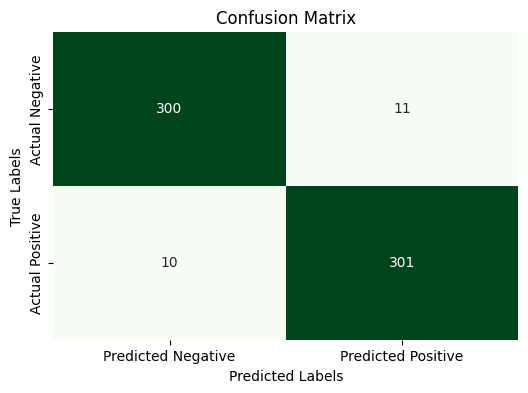

ROC AUC: 0.966


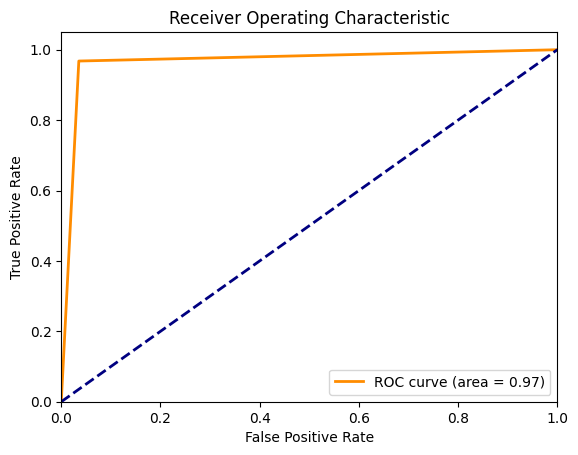

In [40]:
rf_classifier = train_classifier(X_train_tfidf, y_data[0], X_val_tfidf, y_data[1])

#### Evaluation on Test Set.

In [87]:
#@title Evaluation on Test Set. { form-width: "20%" }
# Libraries already installed and imported

def final_evaluation(rf_classifier, X_test_tfidf, y_test):
    # Make predictions on the test set
    y_test_pred = rf_classifier.predict(X_test_tfidf)
    y_pred_prob = rf_classifier.predict_proba(X_test_tfidf)

     # Calculate accuracy, precision, recall
    test_accuracy = accuracy_score(y_test, y_test_pred)  # Calculate accuracy
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)  # Calculate recall ** Adjust 'average' parameter for multi-class
    f1 = f1_score(y_test, y_test_pred)  # Calculate F1 score ** Adjust 'average' parameter for multi-class
    entropy = log_loss(y_test, y_pred_prob)
    print(f'Test Accuracy: {test_accuracy:.3f}')
    print(f'Test Precision: {precision:.3f}')
    print(f'Test Recall: {recall:.3f}')
    print(f'Test F1 Score: {f1:.3f}')
    print(f'Test Entropy: {entropy:.3f}\n')

    # Print classification report
    print('Classification Report:')
    print(classification_report(y_test, y_test_pred))
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))

    # Create a heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])

    # Set labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    roc_auc = auc(fpr, tpr)
    print(f'ROC AUC: {roc_auc:.3f}')

    # Plot the ROC curve

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # return test_accuracy, precision, recall, f1
    return {'accuracy': round(test_accuracy, 2), 'precision': round(precision, 2), 'recall': round(recall, 2), 'f1': round(f1, 2), 'entropy': round(entropy, 2)}
    # return y_test_pred

Test Accuracy: 0.974
Test Precision: 0.957
Test Recall: 0.990
Test F1 Score: 0.973
Test Entropy: 0.299

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       333
           1       0.96      0.99      0.97       290

    accuracy                           0.97       623
   macro avg       0.97      0.98      0.97       623
weighted avg       0.97      0.97      0.97       623

Confusion Matrix:
[[320  13]
 [  3 287]]


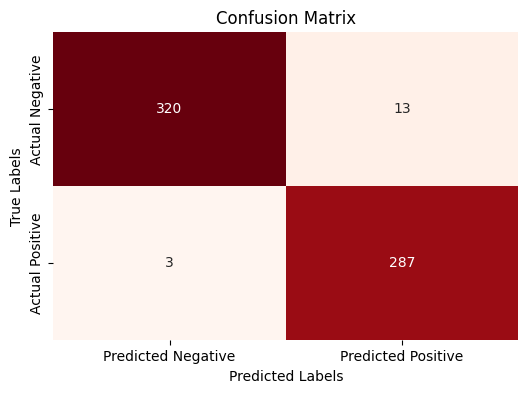

ROC AUC: 0.975


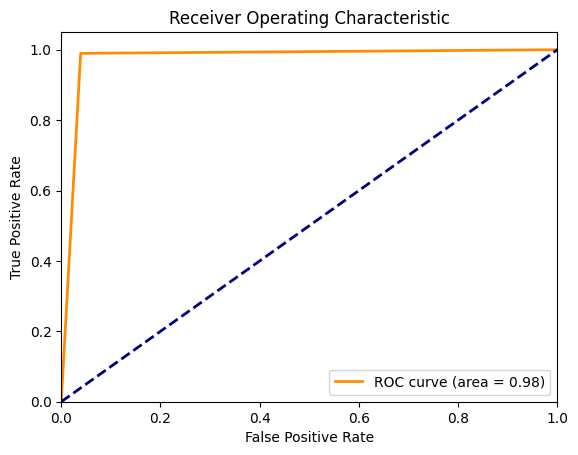

In [88]:
y_test_pred = final_evaluation(rf_classifier, X_test_tfidf, y_data[2])

In [89]:
y_test_pred

{'accuracy': 0.97,
 'precision': 0.96,
 'recall': 0.99,
 'f1': 0.97,
 'entropy': 0.3}

In [74]:
def predict_prob_on_test_data(rf_classifier, X_test_tfidf, y_test):
    # Check probabilities of the predictions on test_set
    y_test_pred = rf_classifier.predict_proba(X_test_tfidf)

    return y_test_pred

In [75]:
y_pred_prob = predict_prob_on_test_data(rf_classifier, X_test_tfidf, y_data[2])

In [76]:
y_pred_prob

array([[0.82, 0.18],
       [0.76, 0.24],
       [0.14, 0.86],
       ...,
       [0.21, 0.79],
       [0.81, 0.19],
       [0.91, 0.09]])

## Save the model

In [66]:
#@title Save the model
import joblib

def save_model(rf_classifier, vectorizer, results_folder):
    model_path = os.path.join(results_folder, 'classifier_model.pkl')
    vectorizer_path = os.path.join(results_folder, 'vectorizer.pkl')

    # Save the model to a file
    joblib.dump(rf_classifier, model_path)
    joblib.dump(vectorizer, vectorizer_path)

    print(f'Model saved to {model_path}')
    print(f'Vectorizer saved to {vectorizer_path}')

    # Load the model from the file
    loaded_model = joblib.load(model_path)
    loaded_vectorizer = joblib.load(vectorizer_path)
    print(f'Loaded model: {loaded_model}')
    print(f'Loaded vectorizer: {loaded_vectorizer}')
    print(f'Loaded vectorizer: {vectorizer}')

    # Use the loaded model for predictions
    # predictions = loaded_model.predict(X_test_tfidf)
    # print(predictions)

    return model_path, vectorizer_path

In [67]:
save_model(rf_classifier, vectorizer, RESULTS_FOLDER)

Model saved to RESULTS\classifier_model.pkl
Vectorizer saved to RESULTS\vectorizer.pkl
Loaded model: RandomForestClassifier(random_state=42)
Loaded vectorizer: TfidfVectorizer(max_features=10000)
Loaded vectorizer: TfidfVectorizer(max_features=10000)


('RESULTS\\classifier_model.pkl', 'RESULTS\\vectorizer.pkl')

## Hyperparameter Tuning

#### Random Forest Classifier Parameters Tuning.

In [102]:
#@title Random Forest Classifier Parameters Tuning. { form-width: "20%" }
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def hyperparameter_tuning(X_train_tfidf, y_train, X_val_tfidf, y_val):

    # Specify hyperparameters and their ranges to tune:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 3, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap':[True, False],
        }

    # Define the parameter grid to search
    # Instantiate RandomForestClassifier within GridSearchCV
    grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state = 77),
                               param_grid = param_grid,
                               cv = 5,
                               n_jobs = -1,
                               verbose = 2,
                               scoring='accuracy',
                               return_train_score=True,
                               refit=True,
                               error_score='raise'
                               )

    # Fit the grid search to the data
    grid_search.fit(X_train_tfidf, y_train)

    # Print the best parameters and corresponding score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    # Get the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print("Best Model:", best_model)

    # Train the final model (RFC) with the best hyperparameters
    best_model = RandomForestClassifier(**best_params, random_state = 77)
    best_model.fit(X_train_tfidf, y_train)

    # Make predictions on the validation set
    y_val_pred = best_model.predict(X_val_tfidf)

    # Calculate accuracy, precision, recall
    val_accuracy = accuracy_score(y_val, y_val_pred)  # Calculate accuracy
    precision = precision_score(y_val, y_val_pred)  # Calculate precision
    recall = recall_score(y_val, y_val_pred)  # Calculate recall
    f1 = f1_score(y_val, y_val_pred)  # Calculate F1 score

    # Print the evaluation metrics
    print(f'Validation Accuracy with Best Parameters: {val_accuracy:.3f}')
    print(f'Validation Precision: {precision:.3f}')
    print(f'Validation Recall: {recall:.3f}')
    print(f'Validation F1 Score: {f1:.3f}\n')

    # Print classification report
    print('Classification Report:')
    print(classification_report(y_val, y_val_pred))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    return best_model

In [103]:
# Evaluate the Final Model on the Test Set
best_model = hyperparameter_tuning(X_train_tfidf, y_data[0], X_val_tfidf, y_data[1])

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: 0.9724458424832335
Best Model: RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                       random_state=77)
Validation Accuracy with Best Parameters: 0.968
Validation Precision: 0.968
Validation Recall: 0.968
Validation F1 Score: 0.968

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       311
           1       0.97      0.97      0.97       311

    accuracy                           0.97       622
   macro avg       0.97      0.97      0.97       622
weighted avg       0.97      0.97      0.97       622

Confusion Matrix:
[[301  10]
 [ 10 301]]


## Final Evaluation of hyperparameter tuned model on Test Set.

In [106]:
#@title Final Evaluation of hyperparameter tuned model on Test Set. { form-width: "20%" }
def evaluate_model_on_test_set(best_model, X_test_tfidf, y_test):
    # Make predictions on the test set
    y_test_pred = best_model.predict(X_test_tfidf)
    y_pred_prob = best_model.predict_proba(X_test_tfidf) #model.predict_proba(X_test)
     
    # Calculate accuracy, precision, recall and F1 score
    test_accuracy = accuracy_score(y_test, y_test_pred)  # Calculate accuracy
    precision = precision_score(y_test, y_test_pred)  # Calculate precision
    recall = recall_score(y_test, y_test_pred)  # Calculate
    f1 = f1_score(y_test, y_test_pred)  # Calculate
    entropy = log_loss(y_test, y_pred_prob)

    # Print the evaluation metrics
    print(f'Test Accuracy: {test_accuracy:.3f}')
    print(f'Test Precision: {precision:.3f}')
    print(f'Test Recall: {recall:.3f}')
    print(f'Test F1 Score: {f1:.3f}\n')

    # Print classification report
    print('Classification Report:')
    print(classification_report(y_test, y_test_pred))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    return {'accuracy': round(test_accuracy, 2), 'precision': round(precision, 2), 'recall': round(recall, 2), 'f1': round(f1, 2), 'entropy': round(entropy, 2)}

In [108]:
y_test_pred = evaluate_model_on_test_set(best_model, X_test_tfidf, y_data[2])

Test Accuracy: 0.978
Test Precision: 0.969
Test Recall: 0.983
Test F1 Score: 0.976

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       333
           1       0.97      0.98      0.98       290

    accuracy                           0.98       623
   macro avg       0.98      0.98      0.98       623
weighted avg       0.98      0.98      0.98       623

Confusion Matrix:
[[324   9]
 [  5 285]]


## MLFlow

Test Accuracy: 0.974
Test Precision: 0.957
Test Recall: 0.990
Test F1 Score: 0.973
Test Entropy: 0.299

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       333
           1       0.96      0.99      0.97       290

    accuracy                           0.97       623
   macro avg       0.97      0.98      0.97       623
weighted avg       0.97      0.97      0.97       623

Confusion Matrix:
[[320  13]
 [  3 287]]


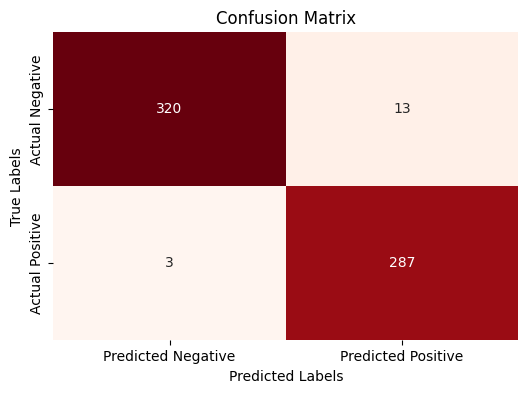

ROC AUC: 0.975


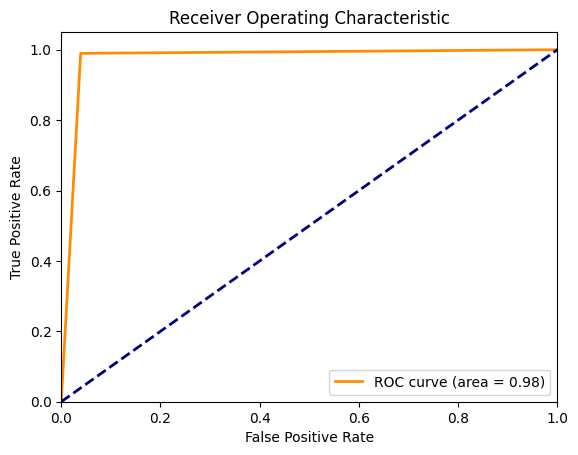

{'accuracy': 0.97, 'precision': 0.96, 'recall': 0.99, 'f1': 0.97, 'entropy': 0.3}


In [90]:
experiment_name = "basic_classifier" #***basic classifier
run_name="term_deposit"
y_test_pred = final_evaluation(rf_classifier, X_test_tfidf, y_data[2])
print(y_test_pred)

In [115]:
create_experiment(experiment_name, run_name, y_test_pred, rf_classifier, 'confusion_matrix.png', 'roc_auc_curve.png')

2024/08/09 17:22:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Run - Grid_Search_CV_Tuned_Model is logged to Experiment - optimized model


#### Create another experiment after hyperparameter tuning; log the best set of parameters for which model gives the optimal performance.

In [113]:
experiment_name = "optimized model"
run_name="Grid_Search_CV_Tuned_Model"
best_model = hyperparameter_tuning(X_train_tfidf, y_data[0], X_val_tfidf, y_data[1])
run_params = best_model.get_params()


y_test_pred = evaluate_model_on_test_set(best_model, X_test_tfidf, y_data[2])

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


C:\Users\TFakorede\AppData\Local\anaconda3\envs\mlflow_env\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: 0.9724458424832335
Best Model: RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                       random_state=77)
Validation Accuracy with Best Parameters: 0.968
Validation Precision: 0.968
Validation Recall: 0.968
Validation F1 Score: 0.968

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       311
           1       0.97      0.97      0.97       311

    accuracy                           0.97       622
   macro avg       0.97      0.97      0.97       622
weighted avg       0.97      0.97      0.97       622

Confusion Matrix:
[[301  10]
 [ 10 301]]
Test Accuracy: 0.978
Test Precision: 0.969
Test Recall: 0.983
Test F1 Score: 0.976

Classification Report:
              precision    recall  f1-score   support

     

#### Function to create an experiment in MLFlow, log parameters, metrics, artifacts and files like images...

In [114]:
create_experiment(experiment_name, run_name, y_test_pred, best_model, 'confusion_matrix.png', 'roc_auc_curve.png', run_params)

C:\Users\TFakorede\AppData\Local\anaconda3\envs\mlflow_env\lib\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\TFakorede\AppData\Local\anaconda3\envs\mlflow_env\lib\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/09 17:21:42 WARNING mlflow.models.model: Input example should be provided to infe

Run - Grid_Search_CV_Tuned_Model is logged to Experiment - optimized model


In [112]:
def create_experiment(experiment_name, run_name, y_test_pred, rf_classifier, confusion_matrix_path = None, 
                      roc_auc_plot_path = None, run_params=None):
    import mlflow
    #mlflow.set_tracking_uri("http://localhost:5000") #uncomment this line if you want to use any database like sqlite as backend storage for model
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run():
        
        if not run_params == None:
             # Assuming run_params is a dictionary, if it's a model, get its parameters
            if isinstance(run_params, dict):
                params_to_log = run_params
            else:
                params_to_log = run_params.get_params()
            
        for metric in y_test_pred:
            mlflow.log_metric(metric, y_test_pred[metric])
        
        mlflow.sklearn.log_model(rf_classifier, "model")
        
        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_materix')
            
        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        mlflow.set_tag("tag1", "Random Forest")
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})
            
    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))